In [153]:
# imports libraries
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal , stats
import math
import sklearn.decomposition as dcmp
import pyaudio
import csv

%matplotlib inline 

# Grabs the preprocessing and automatic_sync files
sys.path.append(os.path.join(os.pardir,'pythonCode'))
import preprocessing as pp
import automatic_sync as autoS
import audio

In [108]:
def sync_dataset(cDataset,indexName,names,max_iter = 2):
    '''
    sDataset = sync_dataset(cDataset,names,max_iter = 2). Syncs the input dataset (dictionary) 
    with corresponding keys (names), recursively determines relative offsets using the cross 
    correlation. 
    Inputs:
        cDataset (dict) - dictionary with raw audio data, each key corresponds to an (Ni,2) array of 1D signals.
        names (list) - keys to the dictionary (data will be synced to names[0])
        max_iter (optional) - maximum number of iterations to be performed.
    Outputs:
        sDataset (dict) - synced dataset (each entry has the same length)
        
    Needed Additions (2/5/2016): needs to return out the final offset values!!
    '''
    
    offsets =  autoS.find_offset(cDataset,indexName,[k  for k in names if k != indexName])
    
    iter_count = 0
    final_offsets ={}
    for name in names:
        final_offsets[name] = 0

    
    
    while abs(sum(offsets.values())) > 0 and iter_count < max_iter:
        syncData = {}
        startInd = 0
        endInd = np.Inf
    
        for name in names:
            if offsets[name] > startInd:
                startInd = offsets[name]
            if offsets[name]+len(cDataset[name][:,0]) < endInd:
                endInd = offsets[name]+len(cDataset[name][:,0])

        for name in names:
            syncData[name] = cDataset[name][startInd-offsets[name]:endInd-offsets[name],:]
            cDataset[name] = syncData[name] 
            assert len(syncData[name]) == endInd - startInd
            final_offsets[name] = final_offsets[name] + startInd-offsets[name]

        offsets = autoS.find_offset(syncData,indexName,[k  for k in names if k != indexName])
        iter_count += 1
        
    
    assert sum(offsets.values()) == 0, print(offsets)
    
    return final_offsets, cDataset

In [91]:
def sync_dataset(cDataset,indexName,names,max_iter = 2):
    '''
    sDataset = sync_dataset(cDataset,names,max_iter = 2). Syncs the input dataset (dictionary)
    with corresponding keys (names), recursively determines relative offsets using the cross
    correlation.
    Inputs:
        cDataset (dict) - dictionary with raw audio data, each key corresponds to an (Ni,2) array of 1D signals.
        names (list) - keys to the dictionary (data will be synced to names[0])
        max_iter (optional) - maximum number of iterations to be performed.
    Outputs:
        sDataset (dict) - synced dataset (each entry has the same length)
    Needed Additions (2/5/2016): needs to return out the final offset values!!
    '''

    offsets = autoS.find_offset(cDataset,indexName,[k  for k in names if k != indexName])

    iter_count = 0
    final_offsets ={}
    for name in names:
        final_offsets[name] = 0


    # if all offsets are zero the while loop will not be entered
    # so set syncData to the original dataset
    if sum(offsets.values()) == 0:
        syncData = cDataset

    while abs(sum(offsets.values())) > 0 and iter_count < max_iter:
        syncData = {}
        startInd = 0
        endInd = np.Inf
                   

        for name in names:
            if offsets[name] > startInd:
                startInd = offsets[name]
            if offsets[name]+len(cDataset[name][:,0]) < endInd:
                endInd = offsets[name]+len(cDataset[name][:,0])

        for name in names:
            syncData[name] = cDataset[name][startInd-offsets[name]:endInd-offsets[name],:]
            # The line below will change the original dataset
            # cDataset[name] = syncData[name]
            final_offsets[name] = final_offsets[name] + startInd-offsets[name]
            
            assert len(syncData[name]) == endInd - startInd

        offsets = autoS.find_offset(syncData,indexName,[k  for k in names if k != indexName])
        iter_count += 1


    # assert sum(offsets.values()) == 0, print(fixedOffsets)

    return final_offsets, syncData

In [111]:
# now reads in the datafile from the raw data folder
rawDataPath = os.path.join(os.pardir,'rawData')
files = glob.glob(os.path.join(rawDataPath, '*.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)

# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);
# Reads the .wav files from the list generted by getKeys
(names,rawDataset) = pp.readWAV(rawDataPath,audioFiles);

cDataset = rawDataset

Opening GP_B1_NU_19 ...
Opening GP_B1_SL_19 ...
Opening GP_B2_NL_19 ...
Opening GP_B2_SL_19 ...
Opening GP_B2_SU_19 ...
Opening GP_B3_NL_19 ...
Opening GP_B3_NU_19 ...
Opening GP_B3_SL_19 ...


In [110]:
final_offsets, syncData = sync_dataset(cDataset,'GP_B3_SL_19',names)
print(final_offsets)

{'GP_B2_SL_19': 89587, 'GP_B3_NU_19': 622, 'GP_B1_NU_19': 188385, 'GP_B2_SU_19': 84624, 'GP_B1_SL_19': 185406, 'GP_B2_NL_19': 84567, 'GP_B3_SL_19': 720, 'GP_B3_NL_19': 1}


2957312
2852895


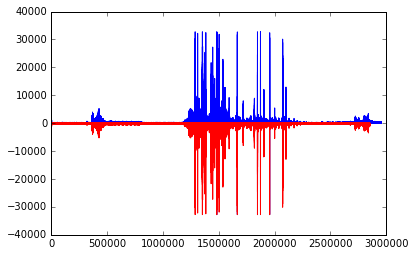

In [113]:
curName = 'GP_B3_NU_19'
print(len(rawDataset[curName][:,0]))
print(len(syncData[curName][:,0]))

plt.plot(abs(rawDataset[curName][final_offsets[curName]:,0]),'b')
plt.plot(-abs(syncData[curName][:,0]),'r')

In [124]:
# Grabs I. Mantawy's estimated fractures from the .csv file
Fs = 48000
csvPath = os.path.join(os.pardir,'rawData')
print(os.path.join(csvPath,'GP_B3_SL_19' + '.csv'))
fileName = glob.glob(os.path.join(csvPath,'GP_B3_SL_19' + '.csv')); 

fractures = list(csv.reader(open(fileName[0], 'rt'), delimiter=','))
rawFractureInd = np.array([int(float(i[0])) for i in fractures]) # in seconds
#fracturesInd = np.array(np.rint(fractures),dtype = int) # in counts
   
print(rawFractureInd) #prints the fractures in counts

..\rawData\GP_B3_SL_19.csv
[1308941 1310843 1351862 1354556 1374331 1376375 1480596 1482502 1501710
 1504754 1534912 1536949 1566979 1568832 1664804 1666861 1845199 1847276
 1872315 1874327 1901178 1903150 2070712 2072636 2100969]


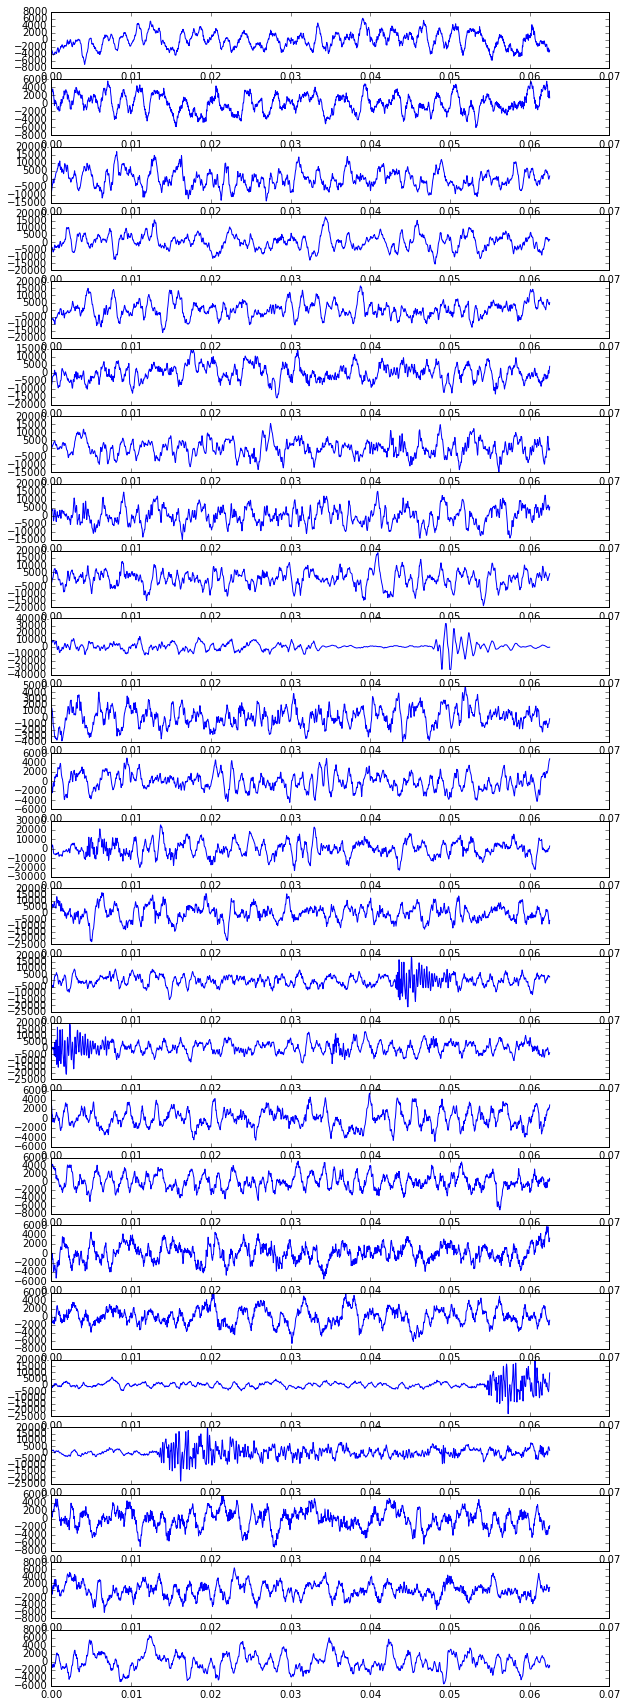

In [223]:
# grabs small chunks of the signal around each identified fracture
curName = names[2]

plt.figure(figsize = (10,30))

clipLength = 3000 #initial guess ~1/20 sec
clips = np.zeros((len(rawFractureInd),clipLength))
features = np.zeros((len(rawFractureInd),5))

for ii in range(len(rawFractureInd)):
    clips[ii,:] = rawDataset[curName][int(rawFractureInd[ii]-clipLength/2):int(rawFractureInd[ii]+clipLength/2),0]
    audio.play_sound(Fs,clips[ii,:])
    f, Pxx_den = signal.periodogram(clips[ii,:], Fs)
    
    # try some features here
    #features[ii,0] = stats.moment(clips[ii,:], moment=2)
    #features[ii,1] = stats.moment(clips[ii,:], moment=3)
    #features[ii,2] = stats.moment(clips[ii,:], moment=4)
    #features[ii,3] = stats.moment(clips[ii,:], moment=5)
    features[ii,4] = np.trapz(Pxx_den[f > 2000],f[f > 2000])
    
    #plt.subplot(clips.shape[0],2,2*ii+1)
    #plt.plot(features[ii,:],'bo')
    #plt.xlim((0,24000))
    #plt.ylim((-10,10**15))
    plt.subplot(clips.shape[0],1,ii+1)
    plt.plot(1/Fs*np.linspace(1,len(clips[ii,:]),len(clips[ii])), clips[ii,:],'b')

GP_B3_NL_19


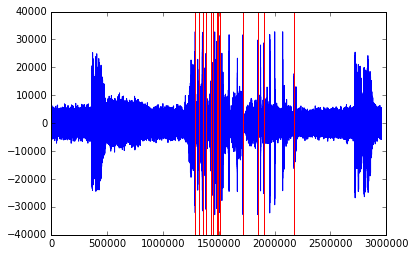

In [240]:
curName = names[5]
print(curName)

FreqLimit = 4000
clipLength = 3000
signalIN = rawDataset[curName][:,0]
clips = int(np.floor(len(signalIN)/clipLength))
a = []

f, Pxx_den = signal.periodogram(rawDataset[curName][:,0], Fs)
baseline =np.trapz(Pxx_den[f > FreqLimit],f[f > FreqLimit])

for ii in range(clips):
    clip = signalIN[ii*clipLength+1:(ii+1)*clipLength]
    f, Pxx_den = signal.periodogram(clip, Fs)
    a.append(np.trapz(Pxx_den[f > FreqLimit],f[f > FreqLimit]))
    
x = clipLength/2+clipLength*np.linspace(0,clips,clips)

plt.plot(signalIN,'b')
plt.plot([x[a > 12*baseline],x[a > 12*baseline]],[-40000,40000],'r')


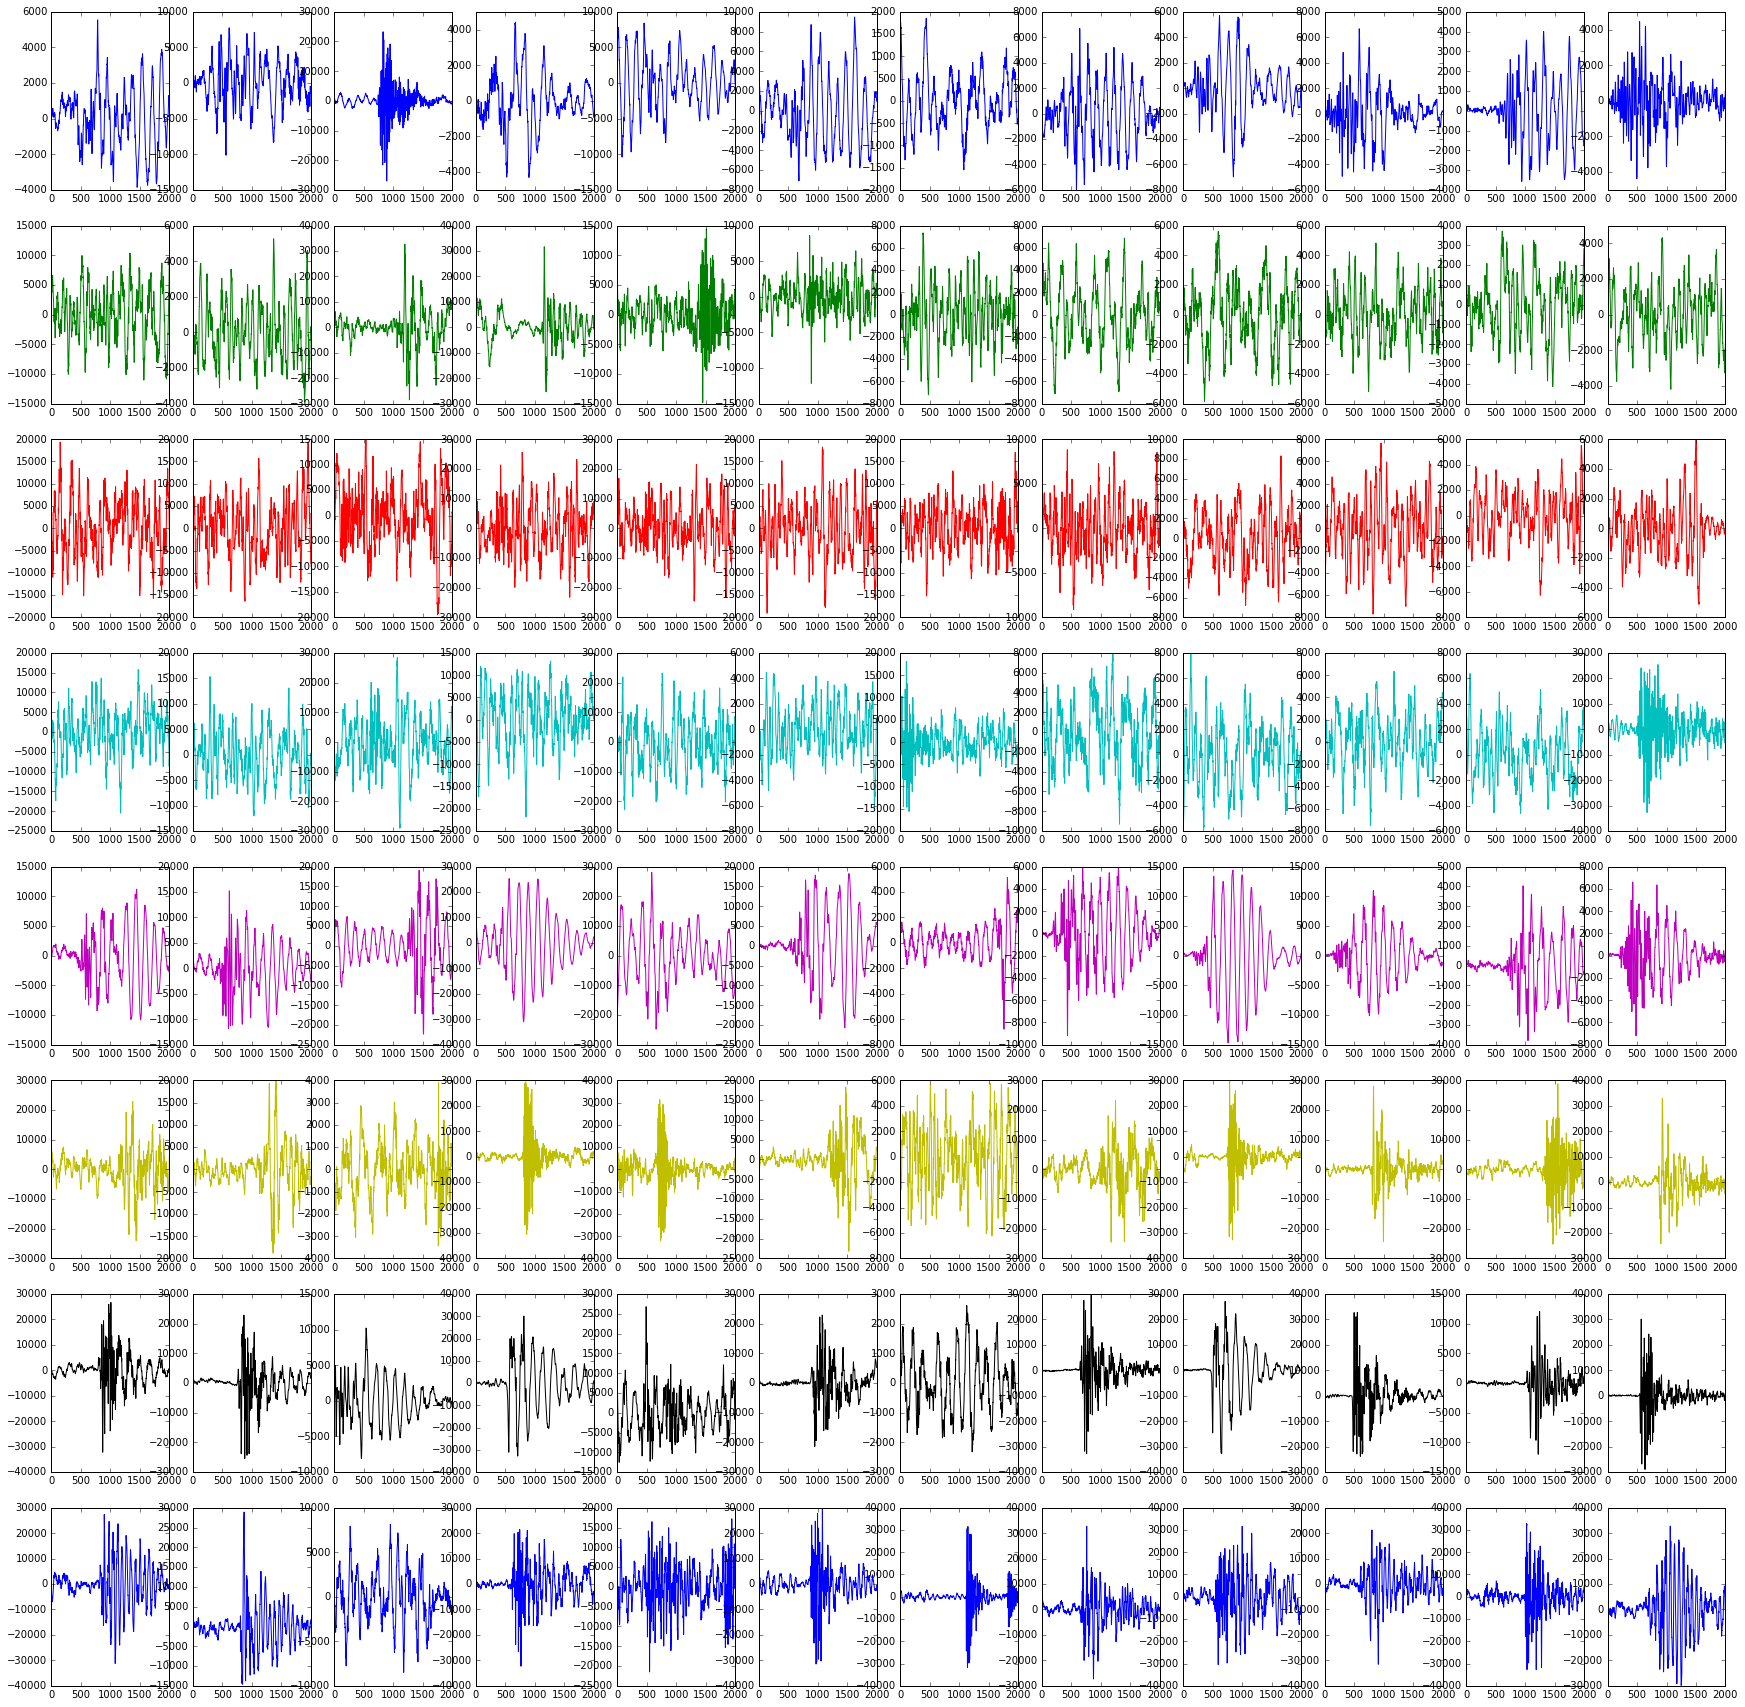

In [260]:
plt.figure(figsize = (30,30))

fractureInd = rawFractureInd - final_offsets['GP_B3_SL_19']


# grabs small chunks of the signal around each identified fracture
curName = names[2]
colors = ['b','g','r','c','m','y','k','b']

clipLength = 2000 #initial guess ~1/20 sec
clips = {}

for jj in range(len(names)):

    clipsi = np.zeros((len(fractureInd),clipLength))
    
    for ii in range(len(fractureInd)):
        clipsi[ii,:] = syncData[names[jj]][int(fractureInd[ii]-clipLength/2):int(fractureInd[ii]+clipLength/2),0]
        #audio.play_sound(Fs,clips[ii,:])
        
    clips[names[jj]] = clipsi    
    
    
 
goodOnes = [1,5,6,7,9,11,13,15,17,19,21,23]
    
for ii in range(len(goodOnes)):
    
    
    for jj in range(len(names)):
        
        plt.subplot(len(names),len(goodOnes),jj*len(goodOnes)+ii+1)
      
        plt.plot(clips[names[jj]][goodOnes[ii],:],colors[jj])


In [266]:
newClips = np.zeros((30,clipLength))

n1 = [[0,1,1,3, 5,5,5,5,5 ,5 ,6,6,6,6,6,6,6,6 ,6 ,7,7,7,7,7,7,7,7,7 ,7],
      [2,2,3,11,0,3,8,9,10,11,0,1,3,5,7,8,9,10,11,0,1,3,5,6,7,8,9,10,11]]

In [285]:
for ii in range(len(n1[0])):
    newClips[ii,:] = clips[names[n1[0][ii]]][goodOnes[n1[1][ii]],:]

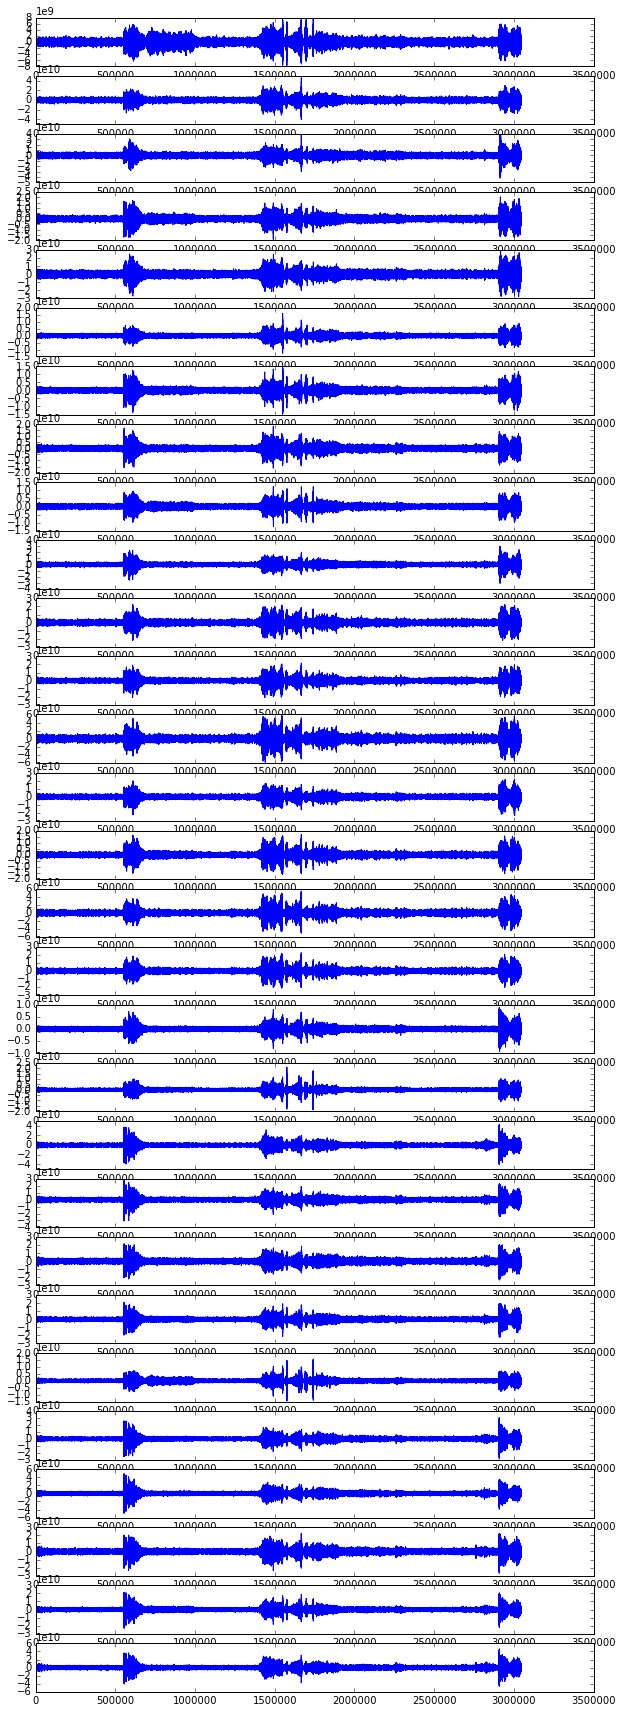

In [298]:
plt.figure(figsize = (10,30))
signalIN = rawDataset[names[1]][:,0] 
#cc = np.zeros(len(signalIN)+1999,)

for ii in range(len(n1[0])):
    cc = signal.fftconvolve(signalIN,newClips[ii,:], mode='full')
    
    plt.subplot(len(n1[0]),1,ii+1)
    plt.plot(cc,'b')
    
    

In [296]:
3045327-len(signalIN)

1999